# Reports for Ashik and Keerthini

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import sys
sys.path.append('/home/ydc19/Projects/chestXrays/utils/')
import labels_utils as lu
import pytorch_dataloaders as ptd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="default")

from pymongo import MongoClient
client = MongoClient()

db_exams = client.chestxrays
col_metadata = db_exams.metadata
col_metadata.estimated_document_count()

2775902

In [3]:
extraction_id = '20210719'

In [4]:
# LOAD

# fn_annotations = '/montana-storage02/chest_xrays/data_reports/AnnotateX_extractions/ax_annotations_xray_' + extraction_id + '.csv'
# Provisional because montana-storage02 is down
# fn_annotations = '/montana-storage/shared/wt_chest_xrays/data_reports/AnnotateX_extractions/ax_annotations_xray_' + extraction_id + '.csv'
# All MS down:
fn_annotations = '/home/ydc19/data/chest_xrays/data_reports/AnnotateX_extractions/ax_annotations_xray_' + extraction_id + '.csv'
fn_collections = '/home/ydc19/data/chest_xrays/data_reports/AnnotateX_extractions/ax_xray_ids_collection_' + extraction_id + '.csv'

df_ann = pd.read_csv(fn_annotations, sep='$').fillna('normal')
df_collection = pd.read_csv(fn_collections)

# Remove "duplicated collections":
df_collection = df_collection[~df_collection.collection_title.isin(['GROUNDTRUTH_0_0', 'GROUNDTRUTH_0_1'])].copy()

In [6]:
# From many rows to list of labels
df_ann = pd.merge(df_ann, df_collection, on=['xray_id', 'collection_id'])
df_gt = df_ann.groupby(['xray_id', 'collection_id', 'collection_title'])['label'].apply(list).reset_index() # This is equivalent to using UNION

# CONVERSION BETWEEN ONTOLOGIES:
df_gt['label'] = df_gt['label'].apply(lambda x : lu.convert_list_of_labels_ontology50_to_ontology45(x))

# Create list with unique labels (set):
df_gt['label'] = df_gt['label'].apply(lambda x : sorted(list(set(x) - set(['normal', 'mark']))))

# Get label_array
df_gt['label_array'] = list(lu.transform_list_of_labels_to_bin_array(list(df_gt['label'])))

/home/ydc19/Projects/chestXrays/utils/labels_utils.py:83: UserWarning: 
You didn't specify the number of labels and this has been set to 38.
                       
In February 2021 we changed from 43 radiological findings to 38.
                       
If you want to use the old labels, please specify num_labels=43 when calling this function.
  \nIf you want to use the old labels, please specify num_labels=43 when calling this function.''')


In [8]:
df_gt.collection_title.unique()

array(['RAND_1K_ABNORMAL_1_GE4', 'GROUNDTRUTH_2', 'GROUNDTRUTH_3',
       'RAND_1K_ABNORMAL_1_LE3', 'GROUNDTRUTH_0', 'GROUNDTRUTH_1',
       'RAND_1K_ABNORMAL_2_ABNORMAL', 'BERT_2K_UNCERTAIN_1_IMPORTANT',
       'RAND_1K_ABNORMAL_3_ABNORMAL', 'RAND_1K_ABNORMAL_3_NORMAL',
       'RAND_1K_NORMAL', 'BERT-RoBERTaXv05_FEW',
       'BERT-RoBERTaXv05_NORMAL', 'RAND_1K_ABNORMAL_2_NORMAL'],
      dtype=object)

In [27]:
# Create "META COLLECTION"
di = {'RAND_1K_ABNORMAL_1_LE3': 'RAND_1K_ABNORMAL_1',
      'RAND_1K_ABNORMAL_1_GE4': 'RAND_1K_ABNORMAL_1',
      'RAND_1K_NORMAL': 'RAND_1K_ABNORMAL_1',
      'RAND_1K_ABNORMAL_2_NORMAL': 'RAND_1K_ABNORMAL_2',
      'RAND_1K_ABNORMAL_2_ABNORMAL': 'RAND_1K_ABNORMAL_2',
      'RAND_1K_ABNORMAL_3_NORMAL': 'RAND_1K_ABNORMAL_3',
      'RAND_1K_ABNORMAL_3_ABNORMAL': 'RAND_1K_ABNORMAL_3',
      'BERT_2K_UNCERTAIN_1_IMPORTANT': 'BERT_2K_UNCERTAIN_1_IMPORTANT',
      'BERT-RoBERTaXv05_NORMAL': 'BERT-RoBERTaXv05',
      'BERT-RoBERTaXv05_FEW': 'BERT-RoBERTaXv05',
      'GROUNDTRUTH_0':'GROUNDTRUTH_0',
      'GROUNDTRUTH_1':'GROUNDTRUTH_1',
      'GROUNDTRUTH_2':'GROUNDTRUTH_2',
      'GROUNDTRUTH_3':'GROUNDTRUTH_3'
     }

df_gt['meta_collection'] = df_gt.collection_title.apply(lambda x : di[x])

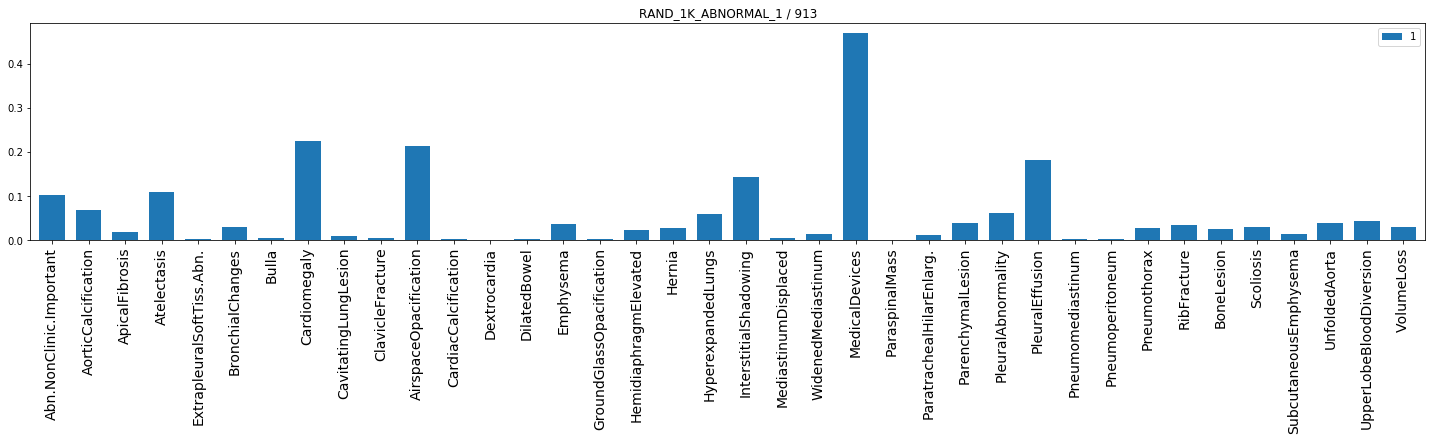

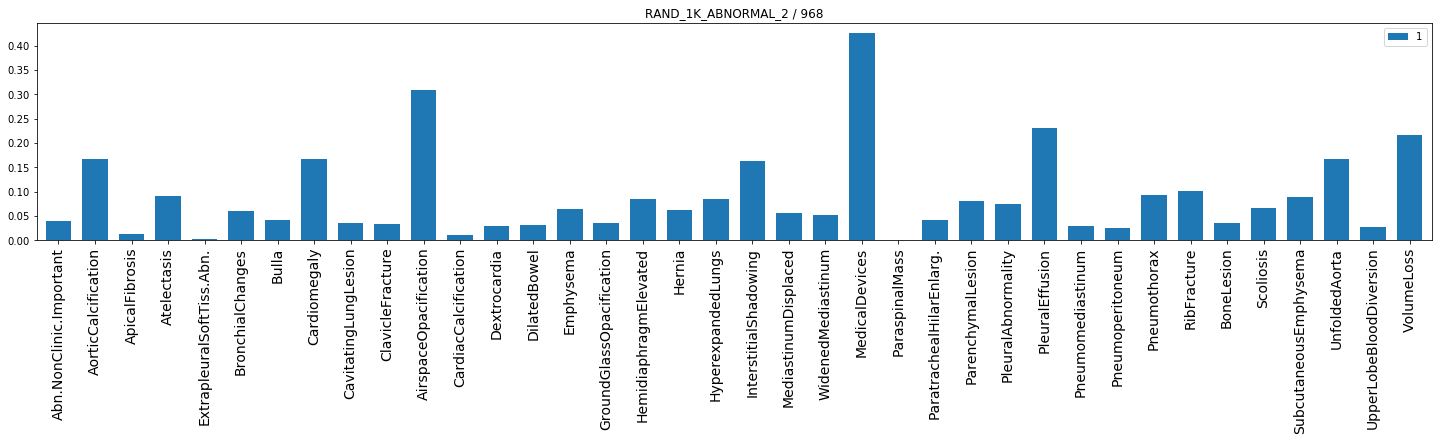

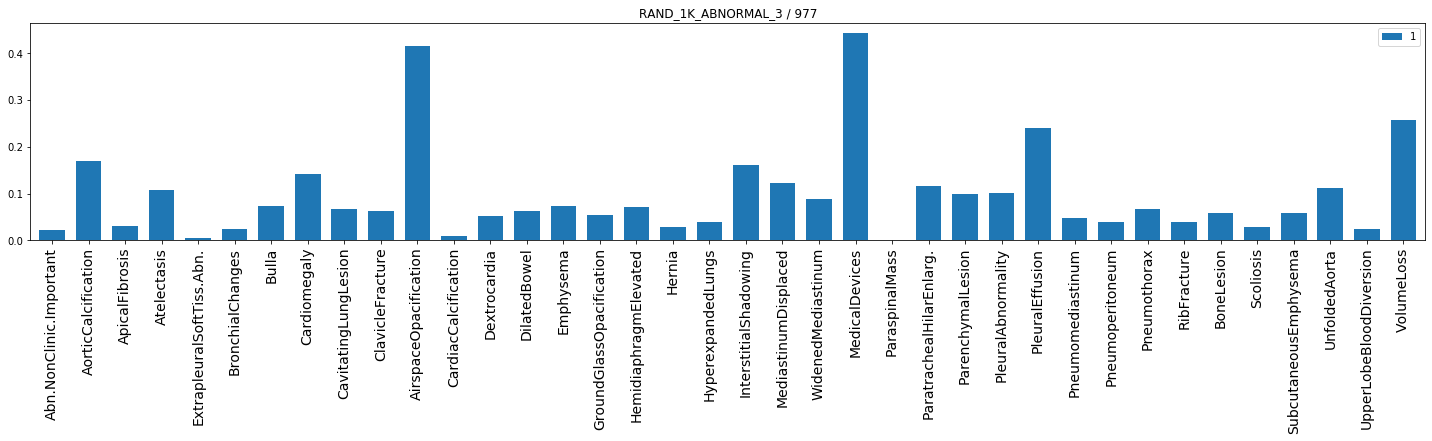

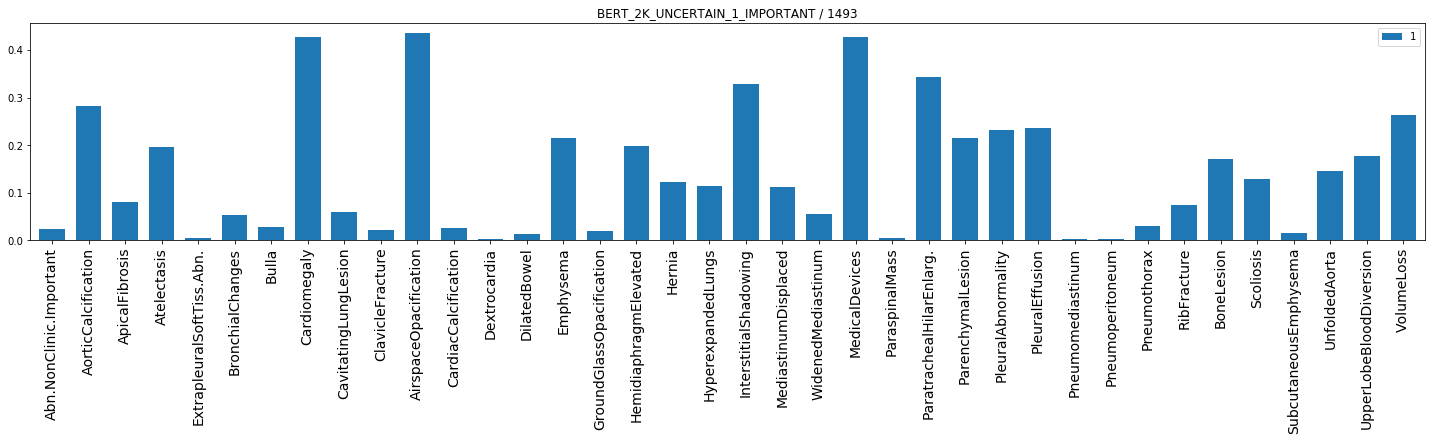

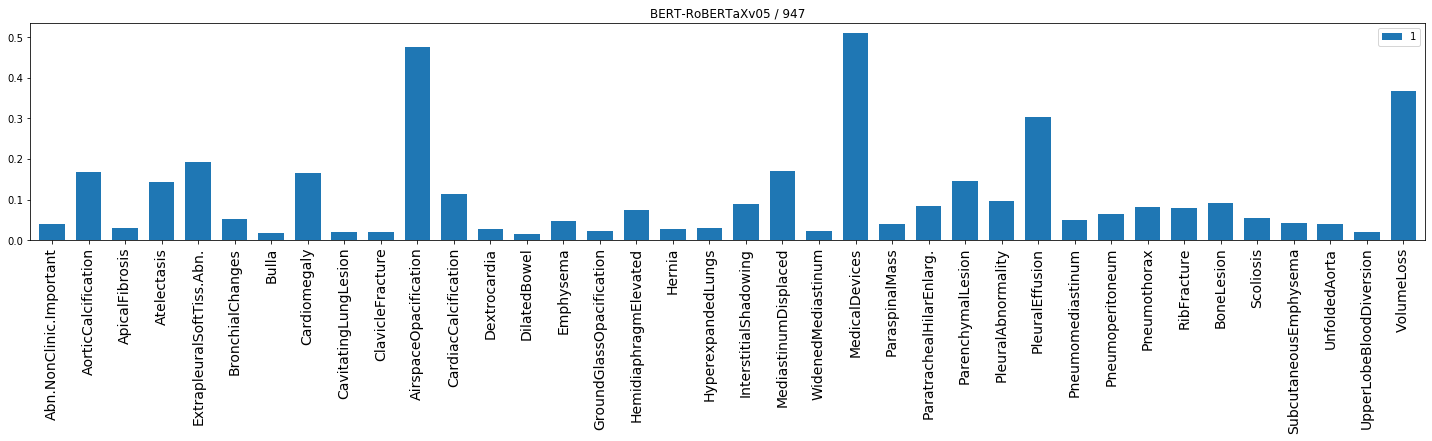

In [28]:
findings = lu.load_list_radiologicalfindings(38)

possible_collections = ['RAND_1K_ABNORMAL_1', 'RAND_1K_ABNORMAL_2', 'RAND_1K_ABNORMAL_3', 'BERT_2K_UNCERTAIN_1_IMPORTANT', 'BERT-RoBERTaXv05']

for c in possible_collections:
    df_aux = df_gt[df_gt.meta_collection == c].copy()
    num_samples = len(df_aux)
    df_aux = pd.DataFrame(list(zip(findings, list(sum(list(df_aux['label_array']))/len(df_aux)))))
    ax = df_aux.plot.bar(figsize=(25,4), width=0.7, title=c + ' / ' + str(num_samples))
    
    _ = ax.set_xticklabels(lu.translate_labels_to_titles(findings))
    ax.tick_params(axis='x', which='major', labelsize=14)

# 26/07/2021: We choose RAND_1K_ABNORMAL_3

1. Create a new x-ray collection
2. Assign X-Rays to a collection
3. Add Prelabels to X-Rays
4. Assign X-Ray collections to users

## 1. Create a New X-Ray Collection
To create a new x-ray collection you can use the SQL script `eg_insert-collection.sql`.

```sql
INSERT INTO ax_xray_collection (id, title, description, create_date)
SELECT MAX(id) + 1                                AS id,
       'RAND_1K_ABNORMAL_3'                       AS title,
       'Xrays from RAND_1K_ABNORMAL_3_NORMAL and RAND_1K_ABNORMAL_3_ABNORMAL xray collections' AS description,
       NOW()                                      AS create_date
FROM ax_xray_collection;
```

## 2. Assign X-Rays to a collection
We will use the exact same assignment already present for the other 2 collections:
- RAND_1K_ABNORMAL_3_NORMAL --> 8
- RAND_1K_ABNORMAL_3_ABNORMAL --> 9

```sql
INSERT INTO ax_labelled_xray (xray, collection, report_annotators)
SELECT xray, 20, report_annotators
FROM ax_labelled_xray
WHERE collection in (8, 9);
```

## 3. Add Prelabels to X-Rays
We will use the exact same pre-labelling already present for the other 2 collections:
- RAND_1K_ABNORMAL_3_NORMAL --> 8
- RAND_1K_ABNORMAL_3_ABNORMAL --> 9
However, we need to change "Any Lobe Collapse" for "VolumeLoss" and "AirspaceOpacification"

```sql
INSERT INTO ax_xray_labelling (xray, collection, label)
SELECT xray, 20, label
FROM ax_xray_labelling
WHERE collection in (8,9)
AND label NOT IN ('left_lower_lobe_collapse', 'left_upper_lobe_collapse', 'right_lower_lobe_collapse', 'right_middle_lobe_collapse', 'right_upper_lobe_collapse', 'volume_loss', 'consolidation');

INSERT INTO ax_xray_labelling (xray, collection, label)
SELECT DISTINCT xray, 20, 'volume_loss'
FROM ax_xray_labelling
WHERE collection in (8,9)
AND label IN ('left_lower_lobe_collapse', 'left_upper_lobe_collapse', 'right_lower_lobe_collapse', 'right_middle_lobe_collapse', 'right_upper_lobe_collapse', 'volume_loss');

INSERT INTO ax_xray_labelling (xray, collection, label)
SELECT DISTINCT xray, 20, 'consolidation'
FROM ax_xray_labelling
WHERE collection in (8,9)
AND label IN ('left_lower_lobe_collapse', 'left_upper_lobe_collapse', 'right_lower_lobe_collapse', 'right_middle_lobe_collapse', 'right_upper_lobe_collapse', 'consolidation');
```

## 4. Assign X-Ray collections to users

- 715 Ashik
- 716 Keerthini
- 707 Yashin

```sql
INSERT INTO ax_xray_assignment (user, collection) values (707, 20);
INSERT INTO ax_xray_assignment (user, collection) values (715, 20);
INSERT INTO ax_xray_assignment (user, collection) values (716, 20);
```

# 07/09/2021: We assign them "1000" more: BERT-RoBERTaXv05

1. Create a new x-ray collection
2. Assign X-Rays to a collection
3. Add Prelabels to X-Rays
4. Assign X-Ray collections to users

## 1. Create a New X-Ray Collection
To create a new x-ray collection you can use the SQL script `eg_insert-collection.sql`.

```sql
INSERT INTO ax_xray_collection (id, title, description, create_date)
SELECT MAX(id) + 1                                AS id,
       'BERT-RoBERTaXv05'                         AS title,
       'Xrays from BERT-RoBERTaXv05_NORMAL and BERT-RoBERTaXv05_FEW xray collections' AS description,
       NOW()                                      AS create_date
FROM ax_xray_collection;
```
New collection inserted with id 21

## 2. Assign X-Rays to a collection
We will use the exact same assignment already present for the other 2 collections:
- BERT-RoBERTaXv05_NORMAL --> 12
- BERT-RoBERTaXv05_FEW --> 13

```sql
INSERT INTO ax_labelled_xray (xray, collection, report_annotators)
SELECT xray, 21, report_annotators
FROM ax_labelled_xray
WHERE collection in (12, 13);
```

## 3. Add Prelabels to X-Rays
We will use the exact same pre-labelling already present for the other 2 collections:
- BERT-RoBERTaXv05_NORMAL --> 12
- BERT-RoBERTaXv05_FEW --> 13
However, we need to change "Any Lobe Collapse" for "VolumeLoss" and "AirspaceOpacification"

```sql
INSERT INTO ax_xray_labelling (xray, collection, label)
SELECT xray, 21, label
FROM ax_xray_labelling
WHERE collection in (12,13)
AND label NOT IN ('left_lower_lobe_collapse', 'left_upper_lobe_collapse', 'right_lower_lobe_collapse', 'right_middle_lobe_collapse', 'right_upper_lobe_collapse', 'volume_loss', 'consolidation');

INSERT INTO ax_xray_labelling (xray, collection, label)
SELECT DISTINCT xray, 21, 'volume_loss'
FROM ax_xray_labelling
WHERE collection in (12,13)
AND label IN ('left_lower_lobe_collapse', 'left_upper_lobe_collapse', 'right_lower_lobe_collapse', 'right_middle_lobe_collapse', 'right_upper_lobe_collapse', 'volume_loss');

INSERT INTO ax_xray_labelling (xray, collection, label)
SELECT DISTINCT xray, 21, 'consolidation'
FROM ax_xray_labelling
WHERE collection in (12,13)
AND label IN ('left_lower_lobe_collapse', 'left_upper_lobe_collapse', 'right_lower_lobe_collapse', 'right_middle_lobe_collapse', 'right_upper_lobe_collapse', 'consolidation');
```

## 4. Assign X-Ray collections to users

- 715 Ashik
- 716 Keerthini
- 707 Yashin

```sql
INSERT INTO ax_xray_assignment (user, collection) values (707, 21);
INSERT INTO ax_xray_assignment (user, collection) values (715, 21);
INSERT INTO ax_xray_assignment (user, collection) values (716, 21);
```